# DMML Assignment 2

- **Name:** Sampad Kumar Kar
- **Roll No.:** BMC201944

- **Name:** Shankar Ram Vasudevan
- **Roll No.:** BMC2018__

# Task

The "Bag of Words" data set from the UCI Machine Learning Repository contains five text collections in the form of bags-of-words. The URL for the UCI repository is [https://archive.ics.uci.edu/ml/datasets/Bag+of+Words](https://archive.ics.uci.edu/ml/datasets/Bag+of+Words).

Our task is to cluster the documents in these datasets via K-means clustering for different values of K and determine an optimum value of K.

As a similarity measure, we use Jaccard index, that measures similarity between two documents based on the overlap of words present in both documents.

The datasets are of different sizes. We report our results on the three smaller datasets (Enron emails, NIPS blog entries, KOS blog entries).

# The Data Set

In each of the text collections, each document is summarized as a bag (multiset) of words. The individual documents are identified by document IDs and the words are identified by word IDs.

After some cleaning up, in each collection the vocabulary of unique words has been truncated to only keep words that occurred more than ten times overall in that collection.

For each collection XYZ:

vocab.XYZ.txt is the vocabulary file, listing all words that appear in the collection XYZ, one word per line. Each word has an implicit wordID that is its line number in this file, starting with 1 (the word on line 1 has wordID 1, the word on line 2 has wordID 2, ...)

docword.XYZ.txt lists out the number of times each word in vocab.XYZ.txt occurs in each document (only non-zero counts are recorded).

The file docword.XYZ.txt begins with 3 header lines

	  D
	  W
	  NNZ
	
where D is the number of documents in the collection, W is the number of words whose frequency is counted (i.e., W is the number of words in vocab.XYZ.txt) and NNZ is the number of non-zero frequency entries for this collection (i.e., NNZ is 3 less than the number of lines in docword.XYZ.txt).

This is followed by NNZ lines of the form

	  docID wordID count
	
where count is the number of time the word with id wordID appears in document with id docID. Remember that only non-zero counts are recorded.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import shuffle

import copy
import random

# Strategy 1

## Data Preprocessing

We will be treating the data corresponding to each document as a binary $W$ dimensional vector, where $W$ is the no. of words in the vocabulary of the dataset (the notation being obvious, we ignore the frequency counts, and presence of a word in a document gives the corresponding feature value of $1$ and $0$ otherwise).

# KOS blog entries

In [28]:
path = './bag-of-words-data/docword.kos.txt.gz'
data_1 = np.genfromtxt(path, delimiter=" ", skip_header = 3, dtype = 'int')
data_2 = np.genfromtxt(path, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [3]:
data_1.shape

(353160, 3)

In [29]:
samples = np.zeros((D,W), dtype=int)

for (d, w, f) in data_1:
    samples[d-1][w-1] = 1

In [5]:
samples.shape

(3430, 6906)

## Strategy 1.1

We first check the code for `n_clusters=4`.

In [6]:
n_clusters = 4

In [7]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=69
)

kmeans.fit(samples)

KMeans(n_clusters=4, random_state=69)

We find the centroid points in each cluster. We do this by taking the argmin of the euclidean distance of each of the data points in a cluster from the cluster centroid as found by the `KMeans` methods. We do so in order to evaluate the Jaccard Score of each cluster w.r.t. this data point and we can't do so if our centroid contains floating point values.

In [8]:
# Helper function - Given the data and center, finds the data-point closest to the center.
from sklearn.metrics.pairwise import euclidean_distances

def closesttocentroid(data, center):
    center_vec = []
    center_vec.append(center)
    center_vec = np.array(center_vec)
    return data[np.argmin(euclidean_distances(data, center_vec))]

We can tweak this function to make a new centroid (which will be a binary vector), based on approximation w.r.t. some threshold, which can be treated as a hyperparameter.

(Will try this later via **Strategy 1.2**)

In [9]:
center_points = np.zeros((n_clusters,W), dtype=int)

for i in range(n_clusters):
    current_cluster = samples[kmeans.labels_ == i]
    current_centroid = kmeans.cluster_centers_[i]
    center_points[i] = closesttocentroid(current_cluster, current_centroid)

Another way of (possibly) identifying the optimum no. of clusters. We check the no. of data points in each clusters. If the no. of points in some of the clusters are disproportionately low, then the clustering algorithm is not working properly.

In [10]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(unique)
print(counts)

[0 1 2 3]
[ 335  331  827 1937]


Evaluating the clustering based on the Jaccard Score. Here, we make use of the built-in `jaccard_score` method from the `sklearn.metrics` module.

In [11]:
jaccard_sum = 0

for i in range(D):
    x = samples[i]
    x_label = kmeans.labels_[i]
    x_center = center_points[x_label]
    jaccard_sum += jaccard_score(x_center, x)

In [12]:
final_score = jaccard_sum/D
final_score

0.08897800095293786

Now, we cluster (pun intended) these steps into a single function which takes in `n_clusters` as argument and returns the jaccard score. This primarily uses the built-in clustering algorithms implemented in `sklearn.cluster` module via the `KMeans` and `MiniBatchKMeans` methods.

In [13]:
def jaccard_avg_score(samples, n_clusters=5, mini_batch=False, batch_size=8192):
    D,W = samples.shape[0],samples.shape[1]
    
    if not (mini_batch):
        kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=5,
            random_state=69
        )
    else:
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            batch_size=batch_size,
            random_state=69,
        )

    kmeans.fit(samples)

    center_points = np.zeros((n_clusters,W), dtype=int)

    for i in range(n_clusters):
        current_cluster = samples[kmeans.labels_ == i]
        current_centroid = kmeans.cluster_centers_[i]
        center_points[i] = closesttocentroid(current_cluster, current_centroid)

    jaccard_sum = 0

    for i in range(D):
        x = samples[i]
        x_label = kmeans.labels_[i]
        x_center = center_points[x_label]
        jaccard_sum += jaccard_score(x_center, x)
    
    final_score = jaccard_sum/D
    return final_score


Let's plot the elbow graph to pin down the optimum no. of clusters. We plot for the `n_clusters` ranging from $1$ to $10$.

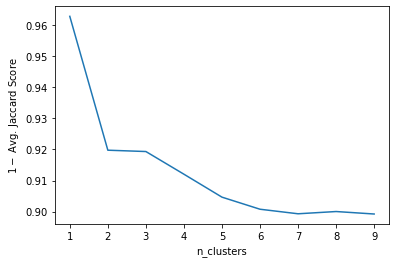

In [14]:
n_clusters_list = np.arange(1,10)
jaccard_list = []
for n in n_clusters_list:
    jaccard_list.append(1-jaccard_avg_score(samples, n))

plt.figure()
plt.plot(n_clusters_list, jaccard_list)
plt.xlabel("n_clusters")
plt.ylabel("$1-$ Avg. Jaccard Score")
plt.show()

We can clearly see an elbow at `n_clusters = 2` from this graph.

At other possible elbow values, we see that there are disproportionate distribution of data, which makes us discard those.

## Strategy 1.2

We tweak the `closestocentroid` method based on the thresholds. Now, instead using the argmin method (with Euclidean Distance) and defining a particular data point in the cluster itself as a centroid, we instead use threshold value to approximate the centroid as computed by the `KMeans` method. So, if for a certain attribute `value > threshold`, we give that particular attribute `1` and `0` otherwise. This also creates a binary vector and we can move on to calculate the jaccard score of a particular cluster w.r.t. this centroid. We treat this `threshold` as a hyperparameter which we tweak while trying to improve the overall jaccard score.

In [15]:
def closesttocentroid2(center, threshold=0.5):
    return np.where(center > threshold, 1, 0)

We combine all these steps into a single function which directly outputs the jaccard score.

In [27]:
def jaccard_avg_score2(samples, n_clusters=5, threshold=0.5, mini_batch=False, batch_size=8192):
    D,W = samples.shape[0],samples.shape[1]
    
    if not (mini_batch):
        kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=5,
            random_state=69
        )
    else:
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            batch_size=batch_size,
            random_state=69,
        )

    kmeans.fit(samples)

    center_points = np.zeros((n_clusters,W), dtype=int)

    for i in range(n_clusters):
        current_centroid = kmeans.cluster_centers_[i]
        center_points[i] = closesttocentroid2(current_centroid, threshold)

    jaccard_sum = 0

    for i in range(D):
        x = samples[i]
        x_label = kmeans.labels_[i]
        x_center = center_points[x_label]
        jaccard_sum += jaccard_score(x_center, x)
    
    final_score = jaccard_sum/D
    
    return final_score
    

Now, we check for different values of `threshold` to pin down on the best value of `threshold` based on the jaccard score it gives.

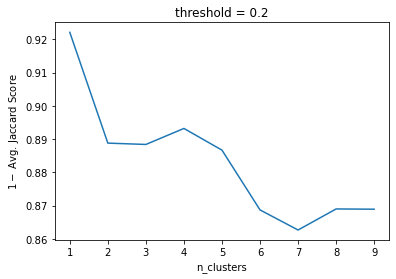

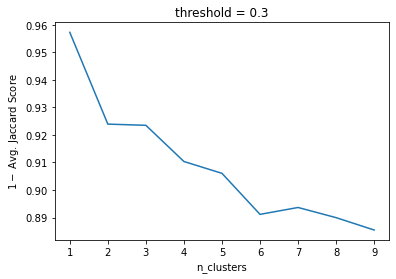

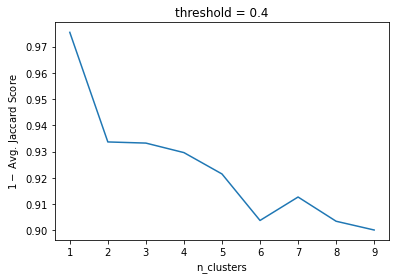

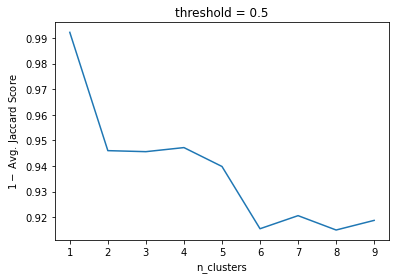

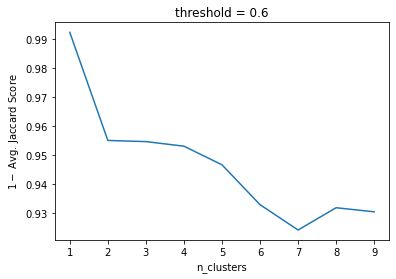

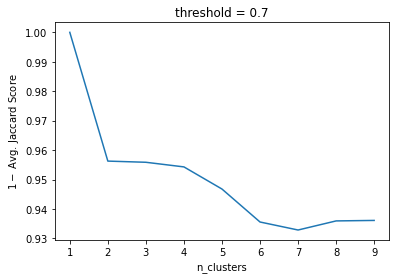

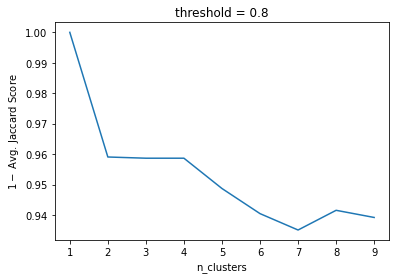

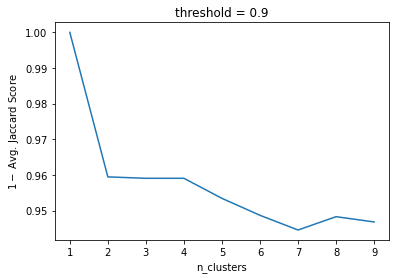

In [30]:
thresholds_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for th in thresholds_list:
    n_clusters_list = np.arange(1,10)
    jaccard_list = []
    for n in n_clusters_list:
        jaccard_list.append(1-jaccard_avg_score2(samples=samples, n_clusters=n, threshold=th))
    plt.figure()
    plt.plot(n_clusters_list, jaccard_list)
    plt.xlabel("n_clusters")
    plt.ylabel("$1-$ Avg. Jaccard Score")
    plt.title("threshold = " + str(th))
    plt.show()

We further fine tune the value of `threshold` based on the jaccard score that they obtain.

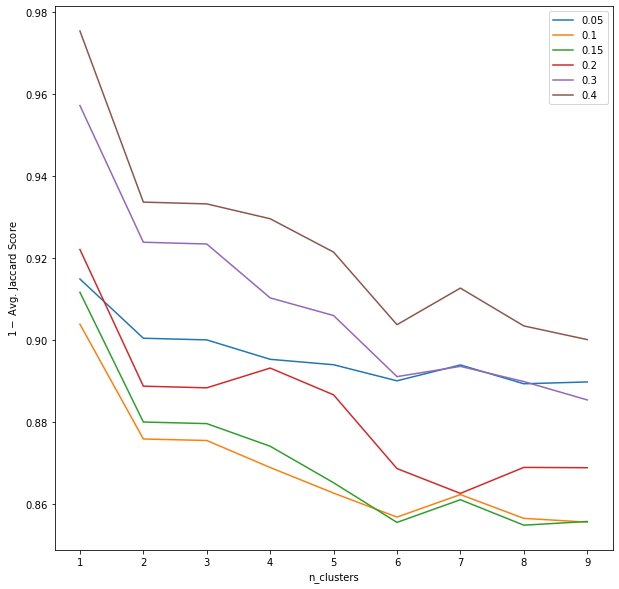

In [31]:
thresholds_list = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4]

plt.figure(figsize=(10,10))
for th in thresholds_list:
    n_clusters_list = np.arange(1,10)
    jaccard_list = []
    for n in n_clusters_list:
        jaccard_list.append(1-jaccard_avg_score2(samples=samples, n_clusters=n, threshold=th))

    plt.plot(n_clusters_list, jaccard_list, label = str(th))
plt.xlabel("n_clusters")
plt.ylabel("$1-$ Avg. Jaccard Score")
plt.legend()
plt.show()

It seems we obtain an elbow at `n_clusters = 2` for the best value of `threshold = 0.1` which gives the best jaccard score (or jaccard error).

# NIPS full papers

In [32]:
path = './bag-of-words-data/docword.nips.txt.gz'
data_1 = np.genfromtxt(path, delimiter=" ", skip_header = 3, dtype = 'int')
data_2 = np.genfromtxt(path, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [33]:
data_1.shape

(746316, 3)

In [34]:
samples = np.zeros((D,W), dtype=int)

for (d, w, f) in data_1:
    samples[d-1][w-1] = 1

In [35]:
samples.shape

(1500, 12419)

## Strategy 1.1

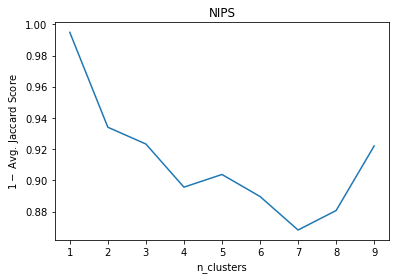

In [36]:
n_clusters_list = np.arange(1,10)
jaccard_list = []
for n in n_clusters_list:
    jaccard_list.append(1-jaccard_avg_score(samples, n))

plt.figure()
plt.plot(n_clusters_list, jaccard_list)
plt.xlabel("n_clusters")
plt.ylabel("$1-$ Avg. Jaccard Score")
plt.title("NIPS")
plt.show()

Here, we get a few prospective values of `n_clusters` at  $2,3$ and $4$. We fine tune this via **Strategy 1.2**.

## Strategy 1.2

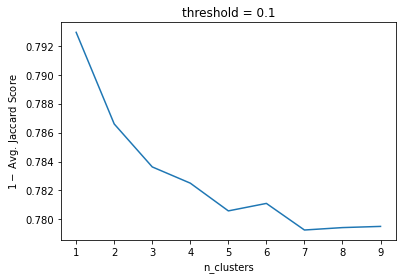

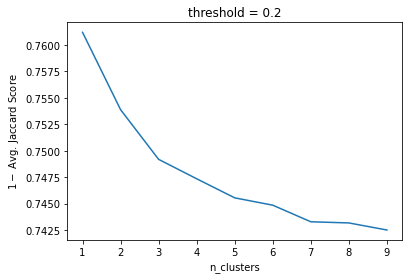

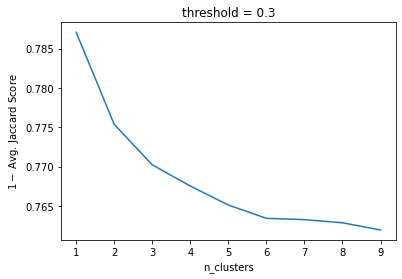

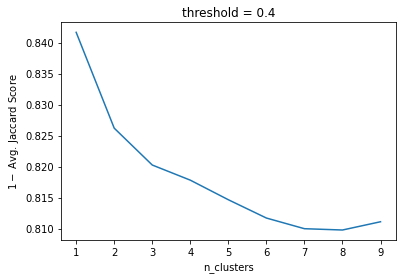

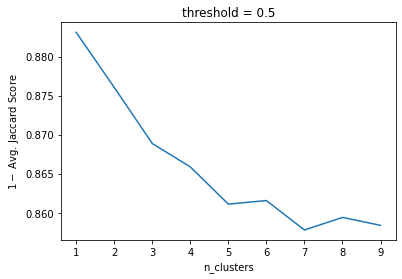

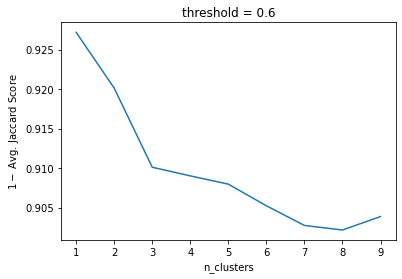

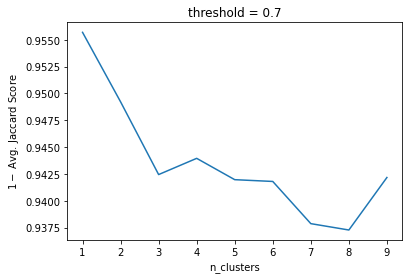

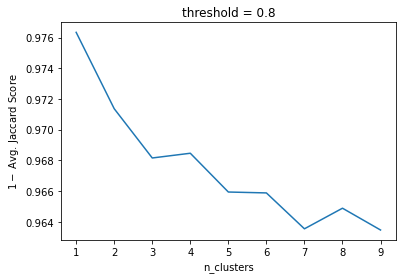

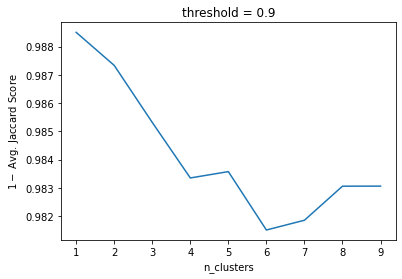

In [37]:
thresholds_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for th in thresholds_list:
    n_clusters_list = np.arange(1,10)
    jaccard_list = []
    for n in n_clusters_list:
        jaccard_list.append(1-jaccard_avg_score2(samples=samples, n_clusters=n, threshold=th))
    plt.figure()
    plt.plot(n_clusters_list, jaccard_list)
    plt.xlabel("n_clusters")
    plt.ylabel("$1-$ Avg. Jaccard Score")
    plt.title("threshold = " + str(th))
    plt.show()

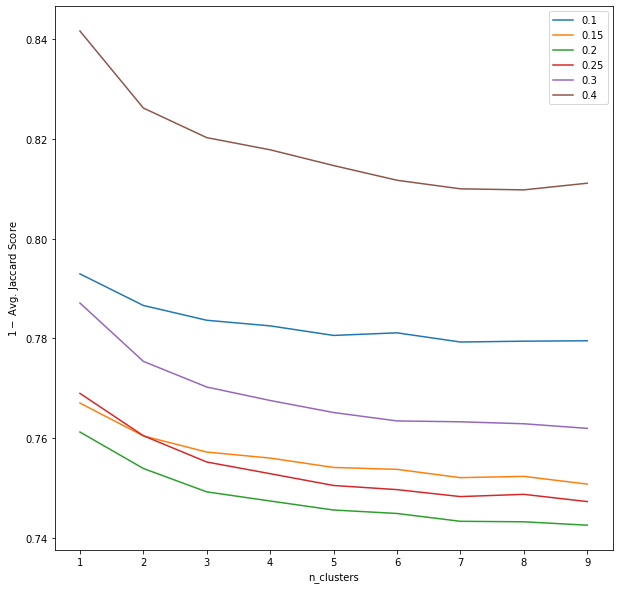

In [38]:
thresholds_list = [0.1, 0.15, 0.2, 0.25 ,0.3, 0.4]

plt.figure(figsize=(10,10))
for th in thresholds_list:
    n_clusters_list = np.arange(1,10)
    jaccard_list = []
    for n in n_clusters_list:
        jaccard_list.append(1-jaccard_avg_score2(samples=samples, n_clusters=n, threshold=th))

    plt.plot(n_clusters_list, jaccard_list, label = str(th))
plt.xlabel("n_clusters")
plt.ylabel("$1-$ Avg. Jaccard Score")
plt.legend()
plt.show()

It seems we obtain an elbow at `n_clusters = 3` or `n_clusters = 5` for the best value of `threshold = 0.2` which gives the best jaccard score (or jaccard error).

We will verify this with subsequent strategies later.

# Enron Emails

In [5]:
path = './bag-of-words-data/docword.enron.txt.gz'
data_1 = np.genfromtxt(path, delimiter=" ", skip_header = 3, dtype = 'int')
data_2 = np.genfromtxt(path, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [6]:
data_1.shape

(3710420, 3)

In [6]:
samples = np.zeros((D,W), dtype=int)

for (d, w, f) in data_1:
    samples[d-1][w-1] = 1

In [7]:
from sklearn.utils import shuffle

samples = shuffle(samples, random_state=0)

In [9]:
samples.shape

(39861, 28102)

Because of the huge size of *Enron* dataset, we make use of `MiniBatchKMeans`.

## Stategy 1.1

### Mini Batch KMeans

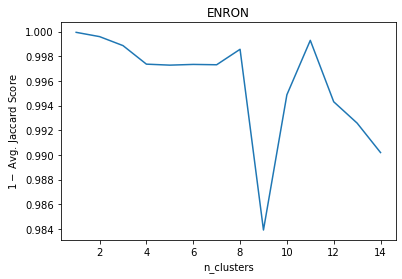

In [12]:
n_clusters_list = np.arange(1,15)
jaccard_list = []
for n in n_clusters_list:
    jaccard_list.append(1-jaccard_avg_score(samples=samples, n_clusters=n, mini_batch=True))

plt.figure()
plt.plot(n_clusters_list, jaccard_list)
plt.xlabel("n_clusters")
plt.ylabel("$1-$ Avg. Jaccard Score")
plt.title("ENRON")
plt.show()   

It seems we get a huge dip in jaccard error at `n_clusters = 9`.

Let's analyse `n_clusters=9`.

In [13]:
kmeans = MiniBatchKMeans(
    n_clusters=9,
    batch_size=8192,
    random_state=69,
)

kmeans.fit(samples)

MiniBatchKMeans(batch_size=8192, n_clusters=9, random_state=69)

In [18]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts

array([    4,     1, 36428,   293,     7,   259,     1,  2867,     1])

Clearly this isn't a good clustering as some clusters have disproportionately high counts and some have have very low counts.

So, let's try `n_clusters=4` to check whether it makes more sense or not.

In [19]:
kmeans = MiniBatchKMeans(
    n_clusters=4,
    batch_size=8192,
    random_state=69,
)

kmeans.fit(samples)

MiniBatchKMeans(batch_size=8192, n_clusters=4, random_state=69)

In [20]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts

array([    6,     2, 38787,  1066])

We again encounter the same problem.

We also try tweaking `max_iter`, `n_init` and `batch_size`.

In [27]:
kmeans = MiniBatchKMeans(
    n_clusters=4,
    max_iter=200,
    n_init=10,
    batch_size=4096,
    random_state=69,
)

kmeans.fit(samples)

unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts

array([ 1137,     1,     1, 38722])

In [21]:
kmeans = MiniBatchKMeans(
    n_clusters=3,
    batch_size=8192,
    random_state=69,
)

kmeans.fit(samples)

unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts

array([    1,    54, 39806])

In [22]:
kmeans = MiniBatchKMeans(
    n_clusters=2,
    batch_size=8192,
    random_state=69,
)

kmeans.fit(samples)

unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts

array([39833,    28])

In [28]:
kmeans = MiniBatchKMeans(
    n_clusters=2,
    max_iter=200,
    n_init=10,
    batch_size=4096,
    random_state=69,
)

kmeans.fit(samples)

unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts

array([    1, 39860])

These clearly don't produce fruitful results, so we resort to **Strategy 1.2**.

## Strategy 1.2

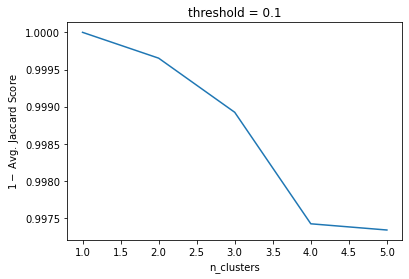

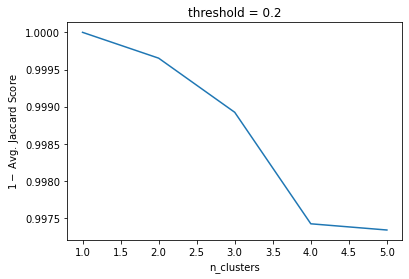

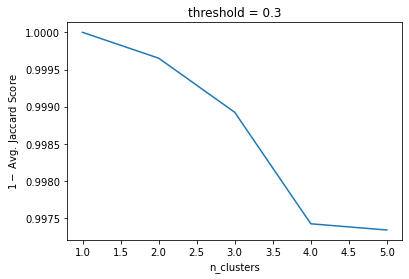

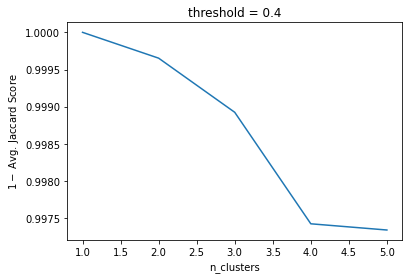

In [31]:
thresholds_list = [0.1, 0.2, 0.3, 0.4, 0.5]
for th in thresholds_list:
    n_clusters_list = np.arange(1,6)
    jaccard_list = []
    for n in n_clusters_list:
        jaccard_list.append(1-jaccard_avg_score2(samples, n, th))
    plt.figure()
    plt.plot(n_clusters_list, jaccard_list)
    plt.xlabel("n_clusters")
    plt.ylabel("$1-$ Avg. Jaccard Score")
    plt.title("threshold = " + str(th))
    plt.show()

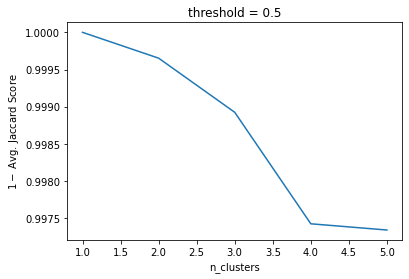

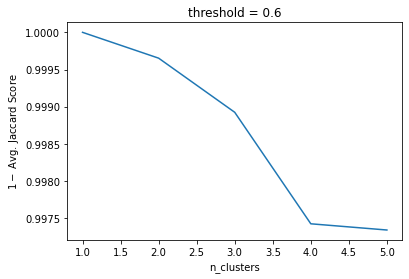

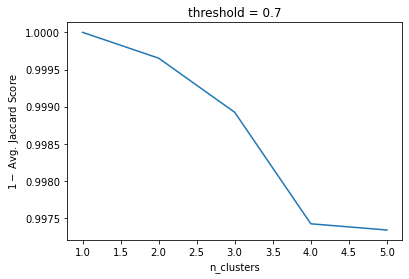

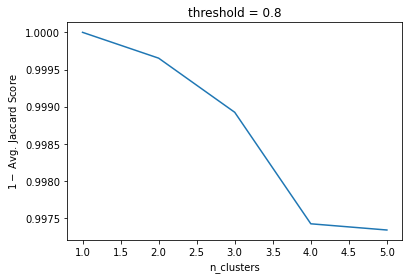

In [8]:
thresholds_list = [0.5, 0.6, 0.7, 0.8]
for th in thresholds_list:
    n_clusters_list = np.arange(1,6)
    jaccard_list = []
    for n in n_clusters_list:
        jaccard_list.append(1-jaccard_avg_score2(samples, n, th))
    plt.figure()
    plt.plot(n_clusters_list, jaccard_list)
    plt.xlabel("n_clusters")
    plt.ylabel("$1-$ Avg. Jaccard Score")
    plt.title("threshold = " + str(th))
    plt.show()

For, different values of thresholds we keep getting approximately similar graphs for the jaccard error (which is also quite). But this seems to give an elbow at `n_clusters = 4`, which could be a possible value of the no. of cluaters.

But, clearly we need some new and efficient strategy to handle the *Enron* dataset.

## Strategy 2

## Data Preprocessing

We will be treating the data corresponding to each document as a set of words i.e., if a word is present in that document, we will add the `wordID` of that particular word to the set corresponding to that document. This is a more efficient way to process the data, instead of the sparse binary representation we were using before.

In [11]:
path = './bag-of-words-data/docword.enron.txt.gz'
data_1 = np.genfromtxt(path, delimiter=" ", skip_header = 3, dtype = 'int')
data_2 = np.genfromtxt(path, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [12]:
samples = {}

for (d, w, f) in data_1:
    if d in samples:
        samples[d].add(w)
    else:
        samples[d] = set()
        samples[d].add(w)

## Strategy 2.1

In this particular strategy, we define our own `jaccardDistance` function, because of the change to sparse set of words representation.

In the `KMeans_Pro` method, we first set the early stopping criterion, and while that is fulfilled, we continue to update our clusters. The key to this algorithm is that we store our data points in sets (clusters are represented as sets) and we update these sets everytime based on the average jaccard distance of a data point from a set to a cluster (we use the jaccard matrix to calculate the average jaccard distance from the data point in interest to all the points in that particular cluster and assign the cluster with minimum average distance to the data point). We iterate through the dataset until the the cluster stabilize.

In [13]:
def jaccardDistance(D1, D2):
    return 1 - float(len(D1.intersection(D2))) / float(len(D1.union(D1)))

In [14]:
def KMeans_Pro(data, n_clusters=2, max_iter=200, tol=10 ,random_state=69):
    np.random.seed(random_state)
    n = len(data)

    # Jaccard Matrix, for storing pairwise jaccard distance
    jaccardMatrix = {}
    for D1 in data:
        jaccardMatrix[D1] = {}
        for D2 in data:
            if D2 not in jaccardMatrix:
                jaccardMatrix[D2] = {}
            jd = jaccardDistance(data[D1], data[D2])
            jaccardMatrix[D1][D2] = jd
            jaccardMatrix[D2][D1] = jd
    
    # Reverse index, Document ID to cluster label
    rev_cluster = {}
    for D in data:
        rev_cluster[D] = -1
    
    # Use the random_state seed to initialize the 'k' intial clusters
    # Store the document ids corresponding to the cluster label
    clusters = {}
    # generate 'k' random no.s between 1 and n (# of docs)
    k_ids = np.random.choice(n, n_clusters, replace=False)
    for k in range(n_clusters):
        clusters[k] = set()
        clusters[k].add(k_ids[k])
        rev_cluster[k_ids[k]] = k

    # initialize the new clusters
    new_clusters = {}
    new_rev_cluster = {}
    for k in range(n_clusters):
        new_clusters[k] = set()

    iterations = 0
    consec_repeat = 1
    while iterations < max_iter and consec_repeat != tol:
        iterations += 1
        if (rev_cluster != new_rev_cluster) and iterations>1:
            consec_repeat = 1
            clusters = copy.deepcopy(new_clusters)
            rev_cluster = copy.deepcopy(new_rev_cluster)
        else:
            consec_repeat += 1
        
        #---- repeated KMeans ----
        # KMeans Step, for calculating the new clusters
        # initialize the new clusters
        new_clusters = {}
        new_rev_cluster = {}
        for k in range(n_clusters):
            new_clusters[k] = set()
        
        # Updating the cluster label for each data point (after each iteration)
        for D1 in data:
            min_dist = np.inf
            min_cluster = rev_cluster[D1]

            # Calculate the minimum average distance to each cluster
            for k in range(n_clusters):
                total_dist = 0
                total_count = 0
                for D2 in clusters[k]:
                    total_dist += jaccardMatrix[D1][D2]
                    total_count += 1
                avg_dist = total_dist/total_count
                if avg_dist < min_dist:
                    min_dist = avg_dist
                    min_cluster = k
            
            # Update the values for this document in new_clusters and new_rev_cluster dictionaries
            new_clusters[min_cluster].add(D1)
            new_rev_cluster[D1] = min_cluster
    
    jaccard_total = 0
    centres = {}
    for k in range(n_clusters):
        current_cluster = clusters[k]
        l = len(current_cluster)
        min_dist, min_centre = np.inf, -1
        for D1 in current_cluster:
            d_score = 0
            for D2 in current_cluster:
                d_score += jaccardMatrix[D1][D2]
            if d_score < min_dist:
                min_dist, min_centre = d_score, D1
        
        centres[k] = min_centre
        jaccard_total += min_dist
    
    jaccard_inertia = jaccard_total/n
    avg_jaccard_score = 1 - jaccard_inertia

    # return the useful attributes
    return clusters, centres, rev_cluster, avg_jaccard_score, jaccard_inertia


We first check for `n_clusters = 4`.

In [25]:
clusters, centres, rev_cluster, avg_jaccard_score, jaccard_inertia = KMeans_Pro(samples, 4, 25, 5)

We then check the average jaccard score for this clustring.

In [26]:
print(avg_jaccard_score)

0.2211202446057251


We get significant improvement in the jaccard score by this technique and this is also significantly faster.

We can also check the quality of clustering by check the counts in each cluster.

In [27]:
for k in clusters.keys():
    print("Count of cluster " + str(k) + " : " + str(len(clusters[k])))

Count of cluster 0 : 396
Count of cluster 1 : 916
Count of cluster 2 : 1609
Count of cluster 3 : 509


This looks like a good clustering because each cluster has a good no. of data points, which makes us believe that the clustering algorithm is functioning well.

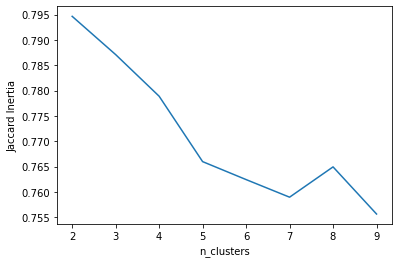

In [28]:
n_clusters_list = np.arange(2,10)
jaccard_list = []
for n in n_clusters_list:
    clusters, centres, rev_cluster, avg_jaccard_score, jaccard_inertia = KMeans_Pro(samples, n, 25, 5)
    jaccard_list.append(jaccard_inertia)

plt.figure()
plt.plot(n_clusters_list, jaccard_list)
plt.xlabel("n_clusters")
plt.ylabel("Jaccard Inertia")
plt.show()

It seems like the ideal no. of clusters should be somewhere around `n_clusters = 4 or n_clusters = 5`. We will verify this with our next strategy aka **Strategy 2.2**!

This is cool and all, but we came up with another strategy (**Strategy 2.2**)! Before checking that we note down a couple of advantages of this strategy:
- It is less space intensive because of the sparse representation.
- It is faster because of the optimized representation of set of words.
- It gives better clustering due to the vastly improved average jaccard score.

## Strategy 2.2

In [2]:
filename = "./bag-of-words-data/docword.enron.txt.gz"
data = np.genfromtxt(filename, delimiter=" ", skip_header = 3, dtype = 'int')
data[:, 2] = 1 #replaces wordcount by 1 for all words.
data_2 = np.genfromtxt(filename, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [6]:
samples = [[] for i in range(D+1)]

for p in data:
    samples[p[0]] += [p[1]]

In [5]:
print(D, W)

39861 28102


In this strategy, we again use the same sparse (set of words) representation to optimise the storage and processing of the data points (which is again what makes this algorithm faster compared to the ones in **Strategy 1**).

In this algorithm we again use thresholding to come up with an appropriate centre w.r.t. a particular cluster (which is used to assign cluster to any example based on the jaccard distance from these centres, like normal `KMeans`), which we update after each iteration over the whole data set.

The question that remains is *how we do this*. Remember that each data point in our dataset is a set of words (`wordID`s). So, we just use thresholding to determine whether a particular word in the vocabulary deserves to be in the centre of this particular cluster. For this we calulate $$\alpha = \frac{\text{no. of documents in this cluster in which this word is present}}{\text{total documents in this cluster}}$$ for each word. If $\alpha > \text{threshold}$, we add the `wordID` corresponding to this word to the set of words corresponding to the centre we are constructing (and we skip the word otherwise).

In [7]:
def JaccardDistance(u, v):
    intersect = 0
    i = 0
    j = 0
    if u == [] and v == []:
        return 0
    while(i < len(u) and j < len(v)):
        if (u[i] == v[j]):
            intersect += 1
            i +=1 
            j += 1
        elif(u[i] < v[j]):
            i += 1
        else:
            j += 1
    s = intersect/(len(u) + len(v) - intersect)
    return 1-s

def iterCentroid(cluster, d):
    k = len(cluster)
    centroid = [[] for i in range(k)]
    for i in range(k):
        wordvec = np.zeros(W +1)
        for j in cluster[i]:
            for word in samples[j]:
                wordvec[word] += 1
        for j in range(len(wordvec)):
            if (wordvec[j]/len(cluster[i])) > d:
                centroid[i] += [j]
    return centroid

def iterCluster(centroid):
    k = len(centroid)
    cluster = [[] for i in range(k)]
    for n in range(1,len(samples)):
        dist = [JaccardDistance(samples[n], centroid[i]) for i in range(k)]
        m = np.argmin(dist)
        cluster[m] += [n]
    return cluster

In [8]:
def KMeans_Pro_2(k, itr, d):
    init = random.sample(range(1, len(samples)), k)
    centroid = [samples[init[i]] for i in range(k)]
    for i in range(itr):
        cluster = iterCluster(centroid)
        centroid = iterCentroid(cluster, d)
    cluster = iterCluster(centroid)
    l1 = 0
    l2 = 0
    lsup = 0
    for i in range(k):
        for j in cluster[i]:
            error = JaccardDistance(samples[j], centroid[i])
            l1 += abs(error)/D 
            l2 += (error*error)/D
            lsup = max(lsup, error)
    return l1, l2, lsup, centroid, cluster

In [8]:
# Setting the threshold
threshold = 0.2

In [9]:
l1curve = []
l2curve = []

for k in range(2,10):
    l1, l2, lsup, centroid, cluster = KMeans_Pro_2(k, min(max(5,2*k),100), threshold)
    l1curve.append(l1)
    l2curve.append(l2)

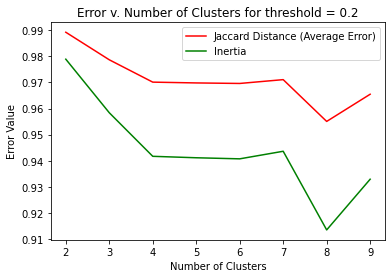

In [10]:
plt.figure()
plt.plot([i for i in range(2,10)], l1curve, color ='r', label = 'Jaccard Distance (Average Error)')
plt.plot([i for i in range(2,10)], l2curve, color ='g', label = 'Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Error Value')
plt.title("Error v. Number of Clusters for threshold = " + str(threshold))
plt.legend(loc='upper right')
plt.show()

As confirmed by **Strategy 2.1** as well, the optimal no. of clusters seems to be around `n_clusters = 4`.

**NOTE:**

We can also employ other techniques like random sampling, to improve the speed, but these algorithms are efficient enough to handle huge datasets (like *Enron*) due to which we do not resort to such methods.

**NOTE:**

These algorithms can also be employed for the *KOS* and *NIPS* datasets. So, we will be repeating these below without going into the detailed explanations.

## KOS

Using **Strategy 2.1**

In [19]:
path = './bag-of-words-data/docword.kos.txt.gz'
data_1 = np.genfromtxt(path, delimiter=" ", skip_header = 3, dtype = 'int')
data_2 = np.genfromtxt(path, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [20]:
samples = {}

for (d, w, f) in data_1:
    if d in samples:
        samples[d].add(w)
    else:
        samples[d] = set()
        samples[d].add(w)

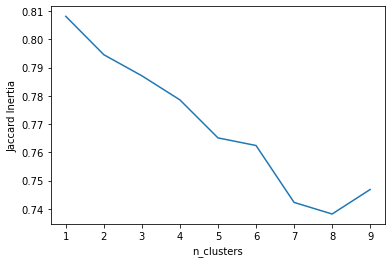

In [29]:
n_clusters_list = np.arange(1,10)
jaccard_list = []
for n in n_clusters_list:
    clusters, centres, rev_cluster, avg_jaccard_score, jaccard_inertia = KMeans_Pro(samples, n, 100, 5)
    jaccard_list.append(jaccard_inertia)

plt.figure()
plt.plot(n_clusters_list, jaccard_list)
plt.xlabel("n_clusters")
plt.ylabel("Jaccard Inertia")
plt.show()

Here, `n_clusters = 2`, `n_clusters = 5` makes sense. But as we confirmed before `n_clusters = 2` seemed more appropriate.

Using **Strategy 2.2**

In [20]:
filename = "./bag-of-words-data/docword.kos.txt.gz"
data = np.genfromtxt(filename, delimiter=" ", skip_header = 3, dtype = 'int')
data[:, 2] = 1 #replaces wordcount by 1 for all words.
data_2 = np.genfromtxt(filename, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [21]:
samples = [[] for i in range(D+1)]

for p in data:
    samples[p[0]] += [p[1]]

In [22]:
print(D, W)

3430 6906


In [23]:
# Setting the threshold
threshold = 0.2

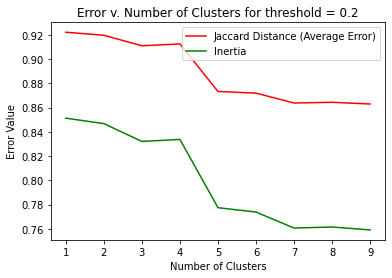

In [24]:
l1curve = []
l2curve = []

for k in range(1,10):
    l1, l2, lsup, centroid, cluster = KMeans_Pro_2(k, min(max(5,2*k),200), threshold)
    l1curve.append(l1)
    l2curve.append(l2)

plt.figure()
plt.plot([i for i in range(1,10)], l1curve, color ='r', label = 'Jaccard Distance (Average Error)')
plt.plot([i for i in range(1,10)], l2curve, color ='g', label = 'Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Error Value')
plt.title("Error v. Number of Clusters for threshold = " + str(threshold))
plt.legend(loc='upper right')
plt.show()

Again as confirmed twice already, `n_clusters = 2`, `n_clusters = 5` makes sense. But as confirmed before `n_clusters = 2` is more appropriate.

## NIPS

Using **Strategy 2.1**

In [30]:
path = './bag-of-words-data/docword.nips.txt.gz'
data_1 = np.genfromtxt(path, delimiter=" ", skip_header = 3, dtype = 'int')
data_2 = np.genfromtxt(path, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [31]:
samples = {}

for (d, w, f) in data_1:
    if d in samples:
        samples[d].add(w)
    else:
        samples[d] = set()
        samples[d].add(w)

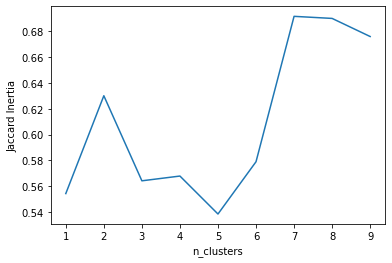

In [32]:
n_clusters_list = np.arange(1,10)
jaccard_list = []
for n in n_clusters_list:
    clusters, centres, rev_cluster, avg_jaccard_score, jaccard_inertia = KMeans_Pro(samples, n, 100, 5)
    jaccard_list.append(jaccard_inertia)

plt.figure()
plt.plot(n_clusters_list, jaccard_list)
plt.xlabel("n_clusters")
plt.ylabel("Jaccard Inertia")
plt.show()

Like our previous observations, `n_clusters = 3` or `n_clusters = 5` makes sense.

Using **Strategy 2.2**

In [25]:
filename = "./bag-of-words-data/docword.nips.txt.gz"
data = np.genfromtxt(filename, delimiter=" ", skip_header = 3, dtype = 'int')
data[:, 2] = 1 #replaces wordcount by 1 for all words.
data_2 = np.genfromtxt(filename, max_rows=2, dtype = 'int')
D,W = data_2[0],data_2[1]

In [26]:
samples = [[] for i in range(D+1)]

for p in data:
    samples[p[0]] += [p[1]]

In [27]:
print(D, W)

1500 12419


In [28]:
# Setting the threshold
threshold = 0.2

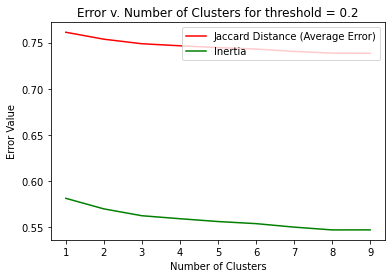

In [29]:
l1curve = []
l2curve = []

for k in range(1,10):
    l1, l2, lsup, centroid, cluster = KMeans_Pro_2(k, min(max(5,2*k),200), threshold)
    l1curve.append(l1)
    l2curve.append(l2)

plt.figure()
plt.plot([i for i in range(1,10)], l1curve, color ='r', label = 'Jaccard Distance (Average Error)')
plt.plot([i for i in range(1,10)], l2curve, color ='g', label = 'Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Error Value')
plt.title("Error v. Number of Clusters for threshold = " + str(threshold))
plt.legend(loc='upper right')
plt.show()

As we can see, `n_clusters = 3` makes most sense here, which is also confirmed by the previous algorithms on this dataset.

# Summary

- We look at various techniques of clustering while using the *Jaccard Similarity* as a measure of closeness.
- We first used the built-in `KMeans` by processing the documents as binary vectors with dimension equal to the no. of words in the vocabulary. We used this for `KOS` and `NIPS`
- Since, the above techniques turned out to be too slow or unreliable (the `MiniBatchKMeans`) for `Enron`, we created $2$ algorithms from scratch to tackle while considering the *Jaccard Distance*. This turned out to be more efficient and accurate with better scores and clusters.

We finally decide on the following results based on our observation:
- *KOS*: `n_clusters = 2`
- *NIPS*: `n_clusters = 3`
- *Enron*: `n_clusters = 4`